In [1]:
import torch
from random import randint
from utilities import chordUtil
from utilities import dataImport
from utilities.chordUtil import *
from utilities.dataImport import *
from sklearn.model_selection import train_test_split
import os
import numpy as np
import random
import sys
import torch.nn as nn
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [3]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
print("use_cuda")
print(use_cuda)
#use_cuda = False
device = torch.device("cuda:0" if use_cuda else "cpu")

use_cuda
True


In [4]:
# Init
lenSeq = 16
#lenSeq = 48
alpha = 'a1'
rootname = "inputs/jazz_xlab/"
filenames = os.listdir(rootname)
#filenames.remove(".DS_Store")
dictChord, listChord = chordUtil.getDictChord(eval(alpha))
print(len(dictChord))
print(dictChord)

37
{'G#:min': 0, 'A:min': 1, 'C:min': 2, 'F:dim': 3, 'F#:maj': 4, 'F#:dim': 5, 'D:dim': 6, 'B:maj': 7, 'D#:maj': 8, 'A#:min': 9, 'D#:dim': 10, 'G:dim': 11, 'C:maj': 12, 'D:maj': 13, 'F:maj': 14, 'N': 15, 'C#:dim': 16, 'B:dim': 17, 'C#:maj': 18, 'B:min': 19, 'F#:min': 20, 'C#:min': 21, 'E:maj': 22, 'D#:min': 23, 'A:maj': 24, 'A#:maj': 25, 'G#:maj': 26, 'A:dim': 27, 'D:min': 28, 'G:maj': 29, 'E:min': 30, 'F:min': 31, 'C:dim': 32, 'E:dim': 33, 'G:min': 34, 'G#:dim': 35, 'A#:dim': 36}


In [5]:
# Create datasets
files_train ,files_test = train_test_split(filenames,test_size=0.7)
dataset_train = dataImport.ChordSeqDataset(files_train, rootname, alpha, dictChord, lenSeq)
dataset_test = dataImport.ChordSeqDataset(files_test, rootname, alpha, dictChord, lenSeq)


In [6]:
# Create generators
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}
training_generator = data.DataLoader(dataset_train, **params)
testing_generator = data.DataLoader(dataset_test, **params)


In [7]:
class MYLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(MYLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers = num_layers, batch_first = True, dropout = 0.1)
        #self.lstm2 = nn.LSTM(input_size, hidden_size, num_layers = num_layers, batch_first = True, dropout = 0.1)
        self.last_fully_connected = nn.Linear(hidden_size, input_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_batch):
        output, (hidden, cell_state) = self.lstm1(input_batch)
        #output, (hidden, cell_state) = self.lstm2(output,(hidden, cell_state))
        #print(output.size(), hidden.size(), cell_state.size())
        output = output[:,-1,:]
        #hidden = hidden[-1,:,:]
        #cell_state = cell_state[-1,:,:]
        #output = torch.cat((output,hidden,cell_state),1)
        output = self.last_fully_connected(output)
        output = self.softmax(output)

        return output

In [8]:
def train(local_batch, local_labels):

    optimizer.zero_grad()
    loss = 0
    
    correct_guess, wrong_guess = 0, 0

    # if tensor of shape 1 in loss function (ex : CrossEntropy)
    local_labels_argmax = torch.tensor([torch.argmax(local_label) for local_label in local_labels]).to(device)
    
    
    
    local_batch, local_labels = local_batch.to(device), local_labels.to(device)    
    
    #output, (hidden, cell_state) = lstm_nn(local_batch)
    #output = output[:,-1,:]
    
    output = lstm_nn(local_batch)
    #print(output.size())
    
    for i in range(len(local_batch)):
        #print(output[i].size(), local_labels[i].size())
        if torch.argmax(output[i]) == torch.argmax(local_labels[i]):
            correct_guess += 1
        else:
            wrong_guess += 1
    
    
    
    loss = criterion(output, local_labels_argmax)
    #loss = criterion(output, local_labels)

    #print(output.size(),local_labels.size())
    
    loss.backward()
    optimizer.step()


    return output, loss.item() / len(local_batch), correct_guess, wrong_guess

In [9]:
def test(local_batch, local_labels):
    loss = 0
    
    correct_guess, wrong_guess = 0, 0

    # if tensor of shape 1 in loss function (ex : CrossEntropy)
    local_labels_argmax = torch.tensor([torch.argmax(local_label) for local_label in local_labels]).to(device)
    
    
    
    local_batch, local_labels = local_batch.to(device), local_labels.to(device)
    
    #output, (hidden, cell_state) = lstm_nn(local_batch)
    #output = output[:,-1,:]
    
    output = lstm_nn(local_batch)

    
    for i in range(len(local_batch)):
        if torch.argmax(output[i]) == torch.argmax(local_labels[i]):
            correct_guess += 1
        else:
            wrong_guess += 1
    loss = criterion(output, local_labels_argmax)
    #loss = criterion(output, local_labels)

    return output, loss.item() / len(local_batch), correct_guess, wrong_guess
    

# Attention

Ici, soit on crée un nouveau réseau, soit on charge un réseau déjà entraîné.

Réseaux déjà entraînés :

"models/lstm_2layers_256blocks_a0.pt"

"models/lstm_2layers_256blocks_a1.pt"

In [21]:
#Init new model

#lstm_nn = nn.LSTM(len(dictChord), len(dictChord), num_layers = lenSeq*5, batch_first = True, dropout = 0.1).to(device)
lstm_nn = MYLSTM(input_size = len(dictChord), hidden_size = 256, num_layers = 2).to(device)


In [13]:
# Or Load previous model
lstm_nn = torch.load("models/lstm_2layers_256blocks_a1.pt").to(device)

In [20]:
save = True
save_path = "models/lstm_2layers_256blocks_a1.pt"
lstm_nn.train(mode=True)



all_losses = []
test_losses = []
total_loss = 0 # Reset every plot_every iters
test_loss = 0

correct_guess_train, wrong_guess_train, correct_guess_test, wrong_guess_test = 0, 0, 0, 0
accuracy_test = []
accuracy_train = []

update_plot = False


start = time.time()

optimizer = torch.optim.Adam(lstm_nn.parameters(), lr = 1e-4)
#print(lstm_nn.parameters())
#optimizer = torch.optim.SGD(lstm_nn.parameters(), lr = 5e2, momentum=0.9)


#criterion = nn.MSELoss()
#criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()


print_every = 20
plot_every = 20
max_epochs = 200


# Begin training
print("Start training")
for epoch in range(1, max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU (nope later...)
        #local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        
        output, loss, correct_guess, wrong_guess = train(local_batch, local_labels)
        #print(loss)
        total_loss += loss
        correct_guess_train += correct_guess
        wrong_guess_train += wrong_guess

    if epoch % print_every == 0:
        accuracy = correct_guess_train/(correct_guess_train+wrong_guess_train)
        print('%s (%d %d%%) train, loss : %.4f, accuracy : %.4f%%' % (timeSince(start), epoch, epoch / max_epochs * 100, loss, accuracy*100))

    if epoch % plot_every == 0:
        accuracy = correct_guess_train/(correct_guess_train+wrong_guess_train)
        all_losses.append(total_loss / (plot_every ))
        accuracy_train.append(accuracy)
        total_loss = 0
        correct_guess_train, wrong_guess_train = 0, 0

        

    # Testing
    for local_batch, local_labels in testing_generator:
        # Transfer to GPU (nope later...)
        #local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        output, loss, correct_guess, wrong_guess  = test(local_batch, local_labels)
        test_loss +=loss
        
        correct_guess_test += correct_guess
        wrong_guess_test += wrong_guess
        

    if epoch % print_every == 0:
        accuracy = correct_guess_test/(correct_guess_test+wrong_guess_test)
        print('%s (%d %d%%) test, loss : %.4f, accuracy : %.4f%%' % (timeSince(start), epoch, epoch / max_epochs * 100, loss, accuracy*100))

    if epoch % plot_every == 0:
        accuracy = correct_guess_test/(correct_guess_test+wrong_guess_test)
        test_losses.append(test_loss / (plot_every ))
        accuracy_test.append(accuracy)
        test_loss = 0
        correct_guess_test, wrong_guess_test = 0, 0
        
        
#experimental feature : plot in realtime
    if update_plot and plot_every ==1:
        if epoch == 1:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            print(range(epoch), accuracy_test)
            li, = ax.plot(epoch, accuracy_test)
            
            ax.relim() 
            ax.autoscale_view(True,True,True)
            fig.canvas.draw()
            plt.show(block=False)
        time.sleep(0.01)
        li.set_data(list(range(epoch)),accuracy_test)
        time.sleep(0.01)
        fig.canvas.draw()
        
print("Finished training")
if save:
    torch.save(lstm_nn, save_path)
    


Start training
0m 24s (20 10%) train, loss : 0.0954, accuracy : 67.9191%
0m 25s (20 10%) test, loss : 0.1607, accuracy : 66.9920%
0m 49s (40 20%) train, loss : 0.0813, accuracy : 68.8277%
0m 50s (40 20%) test, loss : 0.1160, accuracy : 67.7270%
1m 13s (60 30%) train, loss : 0.0807, accuracy : 68.1712%
1m 13s (60 30%) test, loss : 0.1640, accuracy : 67.9152%
1m 36s (80 40%) train, loss : 0.0395, accuracy : 68.6342%
1m 36s (80 40%) test, loss : 0.1843, accuracy : 68.8108%
1m 58s (100 50%) train, loss : 0.0513, accuracy : 69.1501%
1m 59s (100 50%) test, loss : 0.1043, accuracy : 68.8886%
2m 21s (120 60%) train, loss : 0.0832, accuracy : 69.3259%
2m 21s (120 60%) test, loss : 0.2177, accuracy : 68.3743%
2m 43s (140 70%) train, loss : 0.0810, accuracy : 69.8710%
2m 44s (140 70%) test, loss : 0.2432, accuracy : 68.7933%
3m 6s (160 80%) train, loss : 0.0793, accuracy : 70.2403%
3m 6s (160 80%) test, loss : 0.1110, accuracy : 68.4872%
3m 29s (180 90%) train, loss : 0.0533, accuracy : 69.5369%


/home/valentinbilot/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type MYLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Loss :


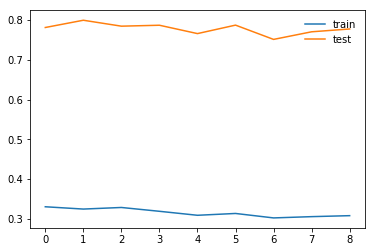

Accuracy :


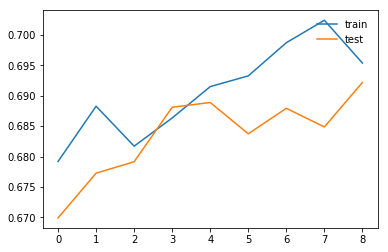

In [22]:
print("Loss :")
plt.figure()
plt.plot(all_losses, label="train")
plt.legend(loc='upper right', frameon=False)
#plt.show()
plt.plot(test_losses, label="test")
plt.legend(loc='upper right', frameon=False)
plt.show()

print("Accuracy :")
plt.figure()
plt.plot(accuracy_train, label="train")
plt.legend(loc='upper right', frameon=False)
#plt.show()
plt.plot(accuracy_test, label="test")
plt.legend(loc='upper right', frameon=False)
plt.show()

# Test avec une grille blues

C'est un peu nul, j'ai l'impression que plus le réseau est entraîné, plus il renvoie des trucs nuls...

In [25]:
if lenSeq == 16:

    test_sequence = ["C:maj","F:maj","C:maj","C:maj",
                     "F:maj","F:maj","C:maj","C:maj",
                     "G:maj","F:maj","C:maj","G:maj",
                     "C:maj","C:maj","F:maj","C:maj"]

if lenSeq == 48:
    test_sequence = ["C:maj","C:maj","C:maj","C:maj","F:maj","F:maj","F:maj","F:maj",
                    "C:maj","C:maj","C:maj","C:maj","C:maj","C:maj","C:maj","C:maj",
                    "F:maj","F:maj","F:maj","F:maj","F:maj","F:maj","F:maj","F:maj",
                    "C:maj","C:maj","C:maj","C:maj","C:maj","C:maj","C:maj","C:maj",
                    "G:maj","G:maj","G:maj","G:maj","F:maj","F:maj","F:maj","F:maj",
                    "C:maj","C:maj","C:maj","C:maj","G:maj","G:maj","G:maj","G:maj"]

test_sequence = test_sequence[0:lenSeq]
test_sequence_tensor = torch.zeros(1, len(test_sequence), len(dictChord)).to(device)
last_chords_output = torch.zeros(1, lenSeq, len(dictChord)).to(device)
for t in range(len(test_sequence)):
    test_sequence_tensor[0, t, dictChord[test_sequence[t]]] = 1
    last_chords_output[0, t, dictChord[test_sequence[t]]] = 1



In [26]:
generation_lenght = 120

generated_sequence = [0 for i in range(generation_lenght)]
generated_sequence[0:lenSeq] = test_sequence

lstm_nn.train(mode=False)

for t in range(generation_lenght-lenSeq):
    if t == 0:
        output = lstm_nn(test_sequence_tensor)
        #generated_sequence[t+lenSeq] = listChord[torch.argmax(output[0,-1]).item()]
        generated_sequence[t+lenSeq] = listChord[torch.argmax(output).item()]
    else : 
        #last_chords_output = torch.zeros(1, lenSeq, len(dictChord)).to(device)
        #for i in range(lenSeq):
            #last_chords_output[0, i, torch.argmax(output[0][-1]).item()] = 1
        #last_chords_output = torch.tensor([[torch.argmax(output[0][i]).item() for i in range(lenSeq)]])
        #print(output.size())
        output = lstm_nn(last_chords_output)
        last_chords_output[0,0:lenSeq-1] = last_chords_output[0,1:lenSeq]
        last_chords_output[0,lenSeq-1] = output
        last_chords_output.to(device)

        
        #output, (hidden, cell_state) = lstm_nn(last_chords_output, (hidden, cell_state))
        #generated_sequence[t+lenSeq] = listChord[torch.argmax(output[0][-1]).item()]
        
        output = lstm_nn(last_chords_output)
        generated_sequence[t+lenSeq] = listChord[torch.argmax(output).item()]

        
for i in range(generation_lenght):
    if i%4 == 0:
        print(generated_sequence[i:i+4])
    if i == lenSeq-1 :
        print("generated :")

['C:maj', 'F:maj', 'C:maj', 'C:maj']
['F:maj', 'F:maj', 'C:maj', 'C:maj']
['G:maj', 'F:maj', 'C:maj', 'G:maj']
['C:maj', 'C:maj', 'F:maj', 'C:maj']
generated :
['B:maj', 'G#:min', 'A#:min', 'A#:min']
['A#:min', 'A#:min', 'A#:min', 'A#:min']
['A#:min', 'A#:min', 'A#:min', 'A#:min']
['A#:min', 'A#:min', 'A#:min', 'A#:min']
['A#:min', 'A#:min', 'A#:min', 'A#:min']
['A#:min', 'A#:min', 'A#:min', 'A#:min']
['A#:min', 'A#:min', 'A#:min', 'A#:min']
['A#:min', 'A#:min', 'A#:min', 'A#:min']
['A#:min', 'A#:min', 'A#:min', 'A#:min']
['A#:min', 'A#:min', 'A#:min', 'A#:min']
['A#:min', 'A#:min', 'A#:min', 'A#:min']
['A#:min', 'A#:min', 'A#:min', 'A#:min']
['A#:min', 'A#:min', 'A#:min', 'A#:min']
['A#:min', 'A#:min', 'A#:min', 'A#:min']
['A#:min', 'A#:min', 'A#:min', 'A#:min']
['A#:min', 'A#:min', 'A#:min', 'A#:min']
['A#:min', 'A#:min', 'A#:min', 'A#:min']
['A#:min', 'A#:min', 'A#:min', 'A#:min']
['A#:min', 'A#:min', 'A#:min', 'A#:min']
['A#:min', 'A#:min', 'A#:min', 'A#:min']
['A#:min', 'A#:min', 